# Market Making with Reinforcement Learning

In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Generic
from collections import defaultdict
from tqdm.auto import tqdm

# Data Visualization
import matplotlib.pyplot as plt 

# Reinforcement Learning
import gym

# Custom Modules
from Libraries import environment as env
from Libraries import agents as ag
from Libraries import approximators as val_approx
from Libraries import tiling
from data.data_gen import DataGenerator

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Set the seed for reproducibility
SEED = 42
np.random.seed(SEED)

## Setup the training environment

In [2]:
dataset_offset = 15000
original_lob_data = DataGenerator._generator('data/lob.csv', levels=1).iloc[dataset_offset:]
horizon = 300
lob_data = original_lob_data.head(horizon+1).values


# Set the boundaries for the state space
boundaries = np.array([lob_data.min(axis=0), lob_data.max(axis=0)]).T * np.array([0.8, 1.2])
boundaries = np.vstack([boundaries, np.array([0, 9])])

In [3]:
# Create the environment
env = env.CustomMarketMakerEnv(
    lob_data=lob_data,
    horizon=horizon,
    phi_transorm=env.PhiTransform.PnL_asymm_dampened(-0.5),
)
initial_state = env.reset()
display(initial_state)

[array([0., 0., 0., 0.]),
 array([ 2.26000000e+02,  4.19000000e+02,  2.25860000e+02,  1.00000000e+02,
         2.25930000e+02,  1.40000000e-01,  0.00000000e+00, -6.14643545e-01,
        -3.19000000e+02,  0.00000000e+00,  6.21303728e-05,  7.85714286e+01])]

### Value function approximator

In [4]:
# Compute spaces bounds
agent_state_bounds = np.array([
    [-1e6, 1e6], # Inventory
    [0,2], # Spread
    [-1,5], # Theta_a
    [-1,5], # Theta_b
])
agent_state_bounds = np.vstack([agent_state_bounds, np.array([0, 9])])

market_state_bounds = np.array([lob_data.min(axis=0), lob_data.max(axis=0)]).T * np.array([0.9, 1.1])
market_state_bounds = np.vstack([market_state_bounds, np.array([0, 9])])

# Define the state space size
size_1 = agent_state_bounds.shape[0]
size_2 = market_state_bounds.shape[0]

# Define discretization parameters
n_tiles = 32
n_tilings = 8
offset = 0.17
n_weights = 1024

# Create value functions
value_function_1 = tiling.SparseTileEncodingApproximator(
    state_dim = size_1,
    bounds = agent_state_bounds,
    n_tiles = n_tiles,
    n_tilings = n_tilings,
    offset = offset,
    n_weights = n_weights,
)
value_function_2 = tiling.SparseTileEncodingApproximator(
    state_dim = size_2,
    bounds = market_state_bounds,
    n_tiles = n_tiles,
    n_tilings = n_tilings,
    offset = offset,
    n_weights = n_weights,
)

# Create the linear combination of the two value functions
lctc_weights = np.array([0.5, 0.5])
value_function = tiling.LCTC_ValueFunction(
    value_functions = [value_function_1, value_function_2],
    lctc_weights    = lctc_weights
)

### Agent

In [5]:
# Define the agent
agent = ag.QLambdaAgent(
    env=env,
    # value_function=tiling.SparseTileEncodingApproximator(
    #     state_dim=lob_data.shape[1],
    #     bounds=boundaries,
    #     n_tiles=16,
    #     n_tilings=8,
    #     offset=0.17,
    #     n_weights=512,
    # ),
    value_function=value_function,
    alpha=1e-3,
    gamma=0.99,
    epsilon=0.2,
    epsilon_decay=0.995, 
    epsilon_min=1e-4,
    el_decay = 0.96
)

# Train the agent
train_rewards, infos = agent.train(n_episodes=200)

Training:   0%|          | 0/200 [00:00<?, ?episode/s]

KeyboardInterrupt: 

The coefficient of the linear regression is: 3.3


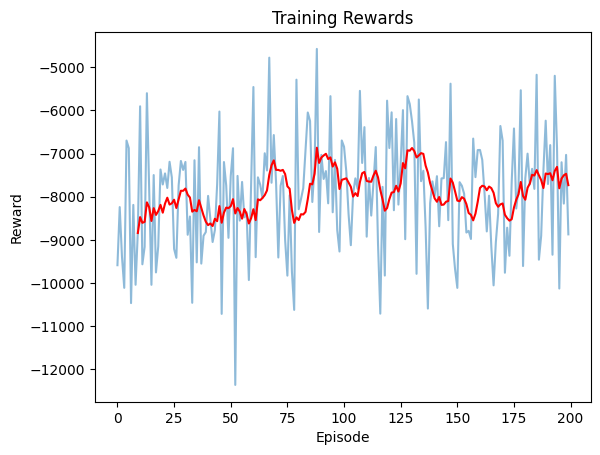

In [ ]:
train_rewards_SMAs = pd.Series(train_rewards).rolling(window=10).mean()
linear_regression = np.polyfit(range(len(train_rewards)), train_rewards, 1)

coef = round(linear_regression[0],1)
print(f'The coefficient of the linear regression is: {coef}')

plt.plot(train_rewards, alpha=0.5)
plt.plot(train_rewards_SMAs, color='red')
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [ ]:
# Test the agent
test_rewards, infos = agent.test(n_episodes=3)

Testing:   0%|          | 0/3 [00:00<?, ?episode/s]

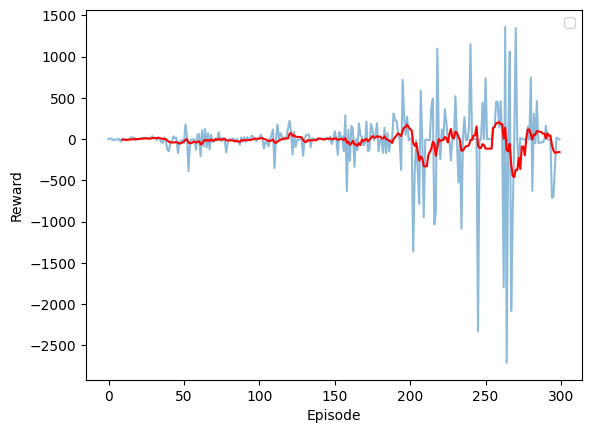

In [ ]:
# Smooth the rewards
sma_window = 10
rewards_sma = pd.Series(test_rewards).rolling(window=sma_window).mean()

# Plot the rewards
plt.plot(test_rewards, alpha=0.5)
plt.plot(rewards_sma, color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

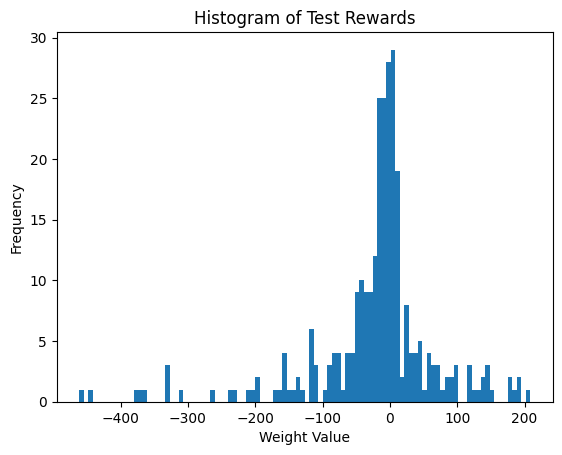

In [ ]:
plt.hist(rewards_sma, bins=100)
plt.title('Histogram of Test Rewards')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.show()

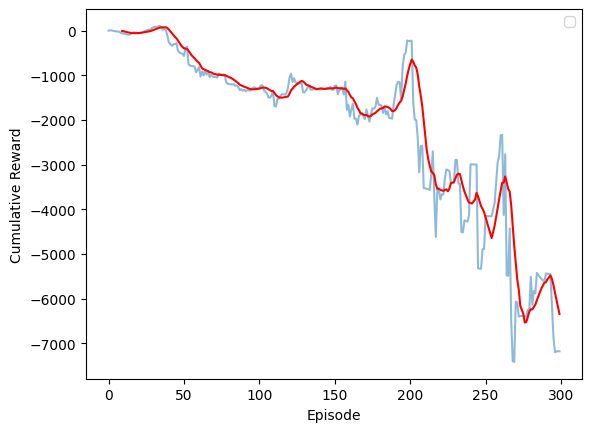

In [ ]:
cumsum = np.cumsum(test_rewards)
cumsu_sma = np.cumsum(rewards_sma)

plt.plot(cumsum, alpha=0.5)
plt.plot(cumsu_sma, color='red')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()

In [ ]:
df_info = pd.DataFrame(infos[-1])

The mean of the inventory is: -19705.676666666666
The standard deviation of the inventory is: 16255.244511003124
The sharpe ratio of the inventory is: -1.2122657800273602


<Axes: >

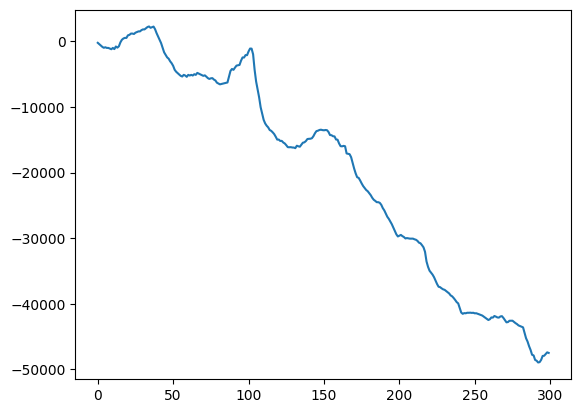

In [ ]:
m, s = df_info['inventory'].mean(), df_info['inventory'].std()
print(f'The mean of the inventory is: {m}')
print(f'The standard deviation of the inventory is: {s}')
print(f'The sharpe ratio of the inventory is: {m/s}')

df_info['inventory'].plot()

The mean of psi is: -6.4
The standard deviation of psi is: 16.5
The sharpe ratio of psi is: -0.39


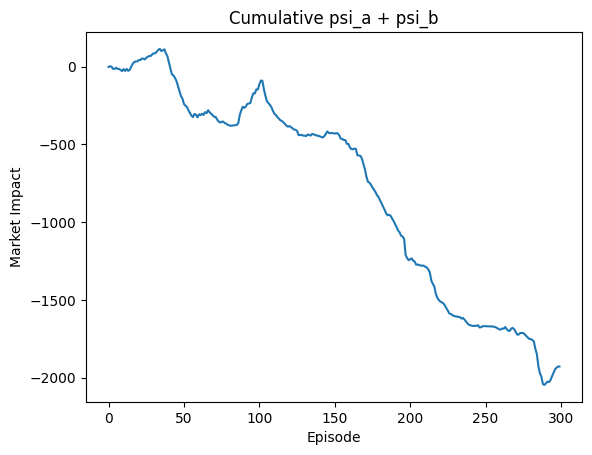

In [ ]:
psi = df_info['psi_a'] + df_info['psi_b']

m, s = psi.mean(), psi.std()
print(f'The mean of psi is: {m:.1f}')
print(f'The standard deviation of psi is: {s:.1f}')
print(f'The sharpe ratio of psi is: {m/s:.2f}')

plt.plot(psi.cumsum())
plt.title('Cumulative psi_a + psi_b')
plt.xlabel('Episode')
plt.ylabel('Market Impact')
plt.show()

<Axes: >

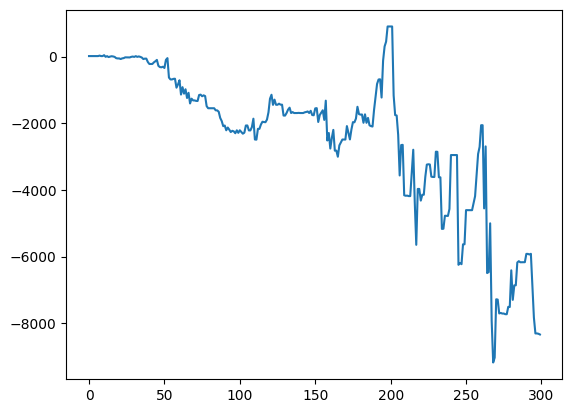

In [ ]:
(df_info['psi_a'] + df_info['psi_a'] + df_info['phi'].cumsum()).plot()